In [3]:
import os
import hashlib
from PIL import Image

def calculate_hash(image_path):

    #Calculate the hash of an image.
    with Image.open(image_path) as img:
        img = img.convert("RGB")  # Ensure the image is in RGB format
        img = img.resize((8, 8))  # Resize to reduce size and create hash
        hash_value = hashlib.md5(img.tobytes()).hexdigest()  # Create hash
    return hash_value

def find_and_remove_duplicates(folder_path):

    #Find and remove duplicate images in a given folder.

    #If cannot find path/ folder, Print that it does not exist
    if not os.path.exists(folder_path):

        print(f"The folder '{folder_path}' may not exist.")
        return

    print(f"Scanning folder: {folder_path}")

    hashes = {}
    duplicates = []

    for filename in os.listdir(folder_path):# for each file in the folder

        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):# if file is an image

            file_path = os.path.join(folder_path, filename) #generate a path to the specific image

            print(f"Processing file: {file_path}")  # Debug output

            img_hash = calculate_hash(file_path)

            if img_hash in hashes:
                duplicates.append(file_path)  # Found a duplicate
                print(f"Duplicate found: {file_path} (duplicate of {hashes[img_hash]})")
            else:
                hashes[img_hash] = file_path

    # Remove duplicates
    for duplicate in duplicates:

        os.remove(duplicate)
        print(f"Removed duplicate: {duplicate}")

    if not duplicates:
        print("No duplicates found.")

if __name__ == '__main__':
    folder = input("Enter the path to the folder containing photos: ")
    find_and_remove_duplicates(folder)

Scanning folder: dataset/test/FAKE
Processing file: dataset/test/FAKE/63.jpg
Processing file: dataset/test/FAKE/848 (2).jpg
Processing file: dataset/test/FAKE/823.jpg
Processing file: dataset/test/FAKE/441 (8).jpg
Processing file: dataset/test/FAKE/90 (8).jpg
Processing file: dataset/test/FAKE/930 (2).jpg
Processing file: dataset/test/FAKE/539 (8).jpg
Processing file: dataset/test/FAKE/451 (8).jpg
Processing file: dataset/test/FAKE/189.jpg
Processing file: dataset/test/FAKE/578 (7).jpg
Processing file: dataset/test/FAKE/858 (2).jpg
Processing file: dataset/test/FAKE/529 (8).jpg
Processing file: dataset/test/FAKE/77.jpg
Processing file: dataset/test/FAKE/80 (8).jpg
Processing file: dataset/test/FAKE/920 (2).jpg
Processing file: dataset/test/FAKE/837.jpg
Processing file: dataset/test/FAKE/400 (7).jpg
Processing file: dataset/test/FAKE/941 (4).jpg
Processing file: dataset/test/FAKE/613 (9).jpg
Processing file: dataset/test/FAKE/214 (8).jpg
Processing file: dataset/test/FAKE/784 (2).jpg
Pr

In [4]:
# Model code starts here
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Correct import
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

# Create an ImageDataGenerator to rescale pixel values
datagen = ImageDataGenerator(rescale=1.0/255.0)  

# Load the images from folders
train_data = datagen.flow_from_directory(
    'dataset/train',  # REPLACE THIS FOR YOUR DIRECTORY
    target_size=(64, 64),  # Resize images to 64x64 pixels
    batch_size=32,         # Load images in batches of 32
    class_mode='binary'    # Since we have two types (fake vs real) use binary mode
)

Found 99079 images belonging to 2 classes.


In [6]:
# Build model
model = Sequential()

# Add an explicit Input layer
model.add(Input(shape=(64, 64, 3)))  # Input layer specifying the image size and 3 channels (RGB)

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu'))  # No need for input_shape here
model.add(MaxPooling2D(pool_size=(2, 2)))  # Max pooling to reduce size

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps into a 1D vector
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))

# Output layer (binary classification: fake vs real)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
#model.summary()

In [7]:
# Train the model
model.fit(train_data, epochs=5)  

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3097/3097 ━━━━━━━━━━━━━━━━━━━━ 226s 73ms/step - accuracy: 0.8279 - loss: 0.3736
Epoch 2/5
3097/3097 ━━━━━━━━━━━━━━━━━━━━ 189s 61ms/step - accuracy: 0.9222 - loss: 0.1968
Epoch 3/5
3097/3097 ━━━━━━━━━━━━━━━━━━━━ 185s 60ms/step - accuracy: 0.9428 - loss: 0.1470
Epoch 4/5
3097/3097 ━━━━━━━━━━━━━━━━━━━━ 183s 59ms/step - accuracy: 0.9538 - loss: 0.1183
Epoch 5/5
3097/3097 ━━━━━━━━━━━━━━━━━━━━ 212s 69ms/step - accuracy: 0.9628 - loss: 0.0951


In [13]:
# Test images here
def predict_images_from_directory(directory):
    results = []

    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist.")
        return []

    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(directory, filename)
            img = load_img(img_path, target_size=(64, 64))  # Use load_img from keras
            img = img_to_array(img)  # Convert image to array
            img = np.expand_dims(img, axis=0)
            img = img / 255.0  # Normalize  image
            
            prediction = model.predict(img)

            if prediction[0][0] >= 0.5:
                results.append((filename, 'Real'))
            else:
                results.append((filename, 'Fake'))

    return results
    
# Path to your directory 
new_image_directory = 'dataset/t'

# Get predictions
predictions = predict_images_from_directory(new_image_directory)

for filename, label in predictions:
    print(f"{filename}: {label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Untitled_Artwork.jpeg: Fake
plague_doctor_049_by_sketchy_zzz_dfsz680-pre.jpg: Real
02b57620-72ab-4f36-abe3-abb97e5770f5.jpeg: Fake
image026.jpeg: Real
4c61a128-8a88-4a64-9c3a-8f11c3d16967.jpeg: Fake
BeautyPlusMe_20171114104433_fast.jpeg: Fake
output.jpg: Fake


Found 19584 images belonging to 2 classes.
612/612 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step
Confusion Matrix:
[[9226  358]
 [ 879 9121]]
Classification Report:
              precision    recall  f1-score   support

        Fake       0.91      0.96      0.94      9584
        Real       0.96      0.91      0.94     10000

    accuracy                           0.94     19584
   macro avg       0.94      0.94      0.94     19584
weighted avg       0.94      0.94      0.94     19584

Precision: 0.96
Recall: 0.91
F1 Score: 0.94


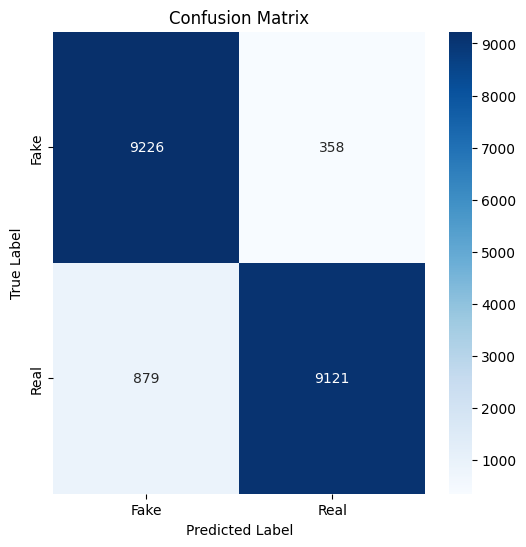

In [11]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score

# Define the directory of test images (organized into subfolders 'Real' and 'Fake')
test_directory = 'dataset/test'  # Replace with your test data directory

# Create an ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for the test set
test_generator = datagen.flow_from_directory(
    test_directory,
    target_size=(64, 64),  # Resize images to match your model's expected input
    batch_size=32,  # You can adjust this value based on your system's memory
    class_mode='binary',  # Binary classification (Real or Fake)
    shuffle=False  # Do not shuffle, as we need to match predictions with true labels
)

# Get the total number of samples
num_samples = test_generator.samples

# Predict using the model on the generator
y_pred_probs = model.predict(test_generator, steps=int(np.ceil(num_samples / test_generator.batch_size)))
y_pred = (y_pred_probs >= 0.5).astype(int).flatten()  # Threshold for binary classification

# Get true labels from the generator
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report (includes Precision, Recall, and F1-Score)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

# Precision, Recall, F1-score (you can calculate them separately too)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot confusion matrix for better visualization
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
